# 🌿 Plant Disease Classification Using Deep Learning

## Project Overview

Plant diseases significantly impact agricultural productivity and food security worldwide. Early and accurate identification of plant diseases enables timely intervention, reduces crop loss, and improves yield quality.

In this notebook, we develop a **Deep Learning–based image classification model** to automatically identify plant diseases from leaf images. The model learns visual patterns such as color changes, texture irregularities, and lesion structures directly from image data.

## Objectives

The main objectives of this project are:

* To build a deep learning model capable of classifying plant leaf images
* To distinguish between healthy and diseased plants (or multiple disease classes)
* To evaluate the model using appropriate performance metrics
* To analyze strengths and limitations of deep learning for agricultural applications


### **Importing Libraries**


In [1]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from PIL import Image
import cv2 as cv
import numpy as np
import plotly.express as px
import math

np.random.seed(42)
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import random
random.seed(42)
torch.manual_seed(42)

from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split
import albumentations as A
from albumentations.pytorch import ToTensorV2

import warnings
warnings.filterwarnings('ignore')

In [2]:
# Set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

Using device: cuda


## Dataset Description

The dataset consists of labeled images of plant leaves belonging to different disease categories.

**Key characteristics:**

* RGB images of plant leaves
* Multiple disease classes (and healthy class, if applicable)
* Variations in lighting, background, and leaf orientation

Each image is associated with a class label representing the plant disease type.

### **Downloading the Dataset from KaggleHub**
This cell uses the `kagglehub` library to download the PlantVillage dataset. The downloaded dataset path is then printed, which will be used for further data loading.

In [3]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("abdallahalidev/plantvillage-dataset")

print("Path to dataset files:", path)

Path to dataset files: /kaggle/input/plantvillage-dataset


### **Loading Image File Paths and Labels**
This cell constructs the base directory for the dataset and then iterates through each disease folder to collect the full file paths of all images and their corresponding labels. It then prints the total number of images and labels found.

In [ ]:
# Load Data
base_dir = os.path.join(path, "color")

folds=os.listdir(base_dir)
print(folds)

filepaths=[]
labels=[]
for fold in folds:
    folder_path=os.path.join(base_dir,fold)
    # print(folder_path)
    imgs=os.listdir(folder_path)
    for img in imgs:
        img_path=os.path.join(folder_path,img)
        filepaths.append(img_path)
        labels.append(fold)
print("Total images:", len(filepaths))
print("Total labels:", len(labels))

['Tomato___Late_blight', 'Tomato___healthy', 'Grape___healthy', 'Orange___Haunglongbing_(Citrus_greening)', 'Soybean___healthy', 'Squash___Powdery_mildew', 'Potato___healthy', 'Corn_(maize)___Northern_Leaf_Blight', 'Tomato___Early_blight', 'Tomato___Septoria_leaf_spot', 'Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot', 'Strawberry___Leaf_scorch', 'Peach___healthy', 'Apple___Apple_scab', 'Tomato___Tomato_Yellow_Leaf_Curl_Virus', 'Tomato___Bacterial_spot', 'Apple___Black_rot', 'Blueberry___healthy', 'Cherry_(including_sour)___Powdery_mildew', 'Peach___Bacterial_spot', 'Apple___Cedar_apple_rust', 'Tomato___Target_Spot', 'Pepper,_bell___healthy', 'Grape___Leaf_blight_(Isariopsis_Leaf_Spot)', 'Potato___Late_blight', 'Tomato___Tomato_mosaic_virus', 'Strawberry___healthy', 'Apple___healthy', 'Grape___Black_rot', 'Potato___Early_blight', 'Cherry_(including_sour)___healthy', 'Corn_(maize)___Common_rust_', 'Grape___Esca_(Black_Measles)', 'Raspberry___healthy', 'Tomato___Leaf_Mold', 'Tomato__

### **Creating a Pandas DataFrame** & **Analyzing Class Distribution**
This cell creates a pandas DataFrame from the collected `filepaths` and `labels`, and displays the count of images for each plant disease class in the dataset, providing an overview of the class distribution.

In [ ]:
# Create DataFrame 
data_df = pd.Series(filepaths, name='filepaths')
label_df = pd.Series(labels, name='labels')
data = pd.concat([data_df, label_df], axis=1)
display(data.labels.value_counts())

# Create label encoding
unique_labels = data['labels'].unique()
label_to_idx = {label: idx for idx, label in enumerate(unique_labels)}
idx_to_label = {idx: label for label, idx in label_to_idx.items()}

data['label_idx'] = data['labels'].map(label_to_idx)

print(f"Number of classes: {len(unique_labels)}")


labels
Orange___Haunglongbing_(Citrus_greening)              5507
Tomato___Tomato_Yellow_Leaf_Curl_Virus                5357
Soybean___healthy                                     5090
Peach___Bacterial_spot                                2297
Tomato___Bacterial_spot                               2127
Tomato___Late_blight                                  1909
Squash___Powdery_mildew                               1835
Tomato___Septoria_leaf_spot                           1771
Tomato___Spider_mites Two-spotted_spider_mite         1676
Apple___healthy                                       1645
Tomato___healthy                                      1591
Blueberry___healthy                                   1502
Pepper,_bell___healthy                                1478
Tomato___Target_Spot                                  1404
Grape___Esca_(Black_Measles)                          1383
Corn_(maize)___Common_rust_                           1192
Grape___Black_rot                                

Number of classes: 38


### **Visualizing Class Distribution**
This cell generates an interactive bar chart using `plotly.express` to visualize the distribution of different plant disease classes. The chart provides a clear representation of how many images are available for each label.

In [6]:
label_counts = data.labels.value_counts().reset_index()
label_counts.columns = ['Label', 'Count']

fig = px.bar(label_counts,x='Label',y='Count',color='Count',color_continuous_scale='Greens',title='🌿 Class Distribution in PlantVillage Dataset',)

fig.update_layout(
    xaxis_title="Plant Disease Classes",
    yaxis_title="Number of Images",xaxis_tickangle=-45,title_font=dict(size=22, color='#1b5e20', family='Arial'),plot_bgcolor='rgba(0,0,0,0)',
    paper_bgcolor='rgba(0,0,0,0)',)

fig.show()

### **Displaying Sample Images**
This cell displays a grid of 6 random sample images from the dataset, along with their respective labels. This helps in visually inspecting the diversity and quality of the images.

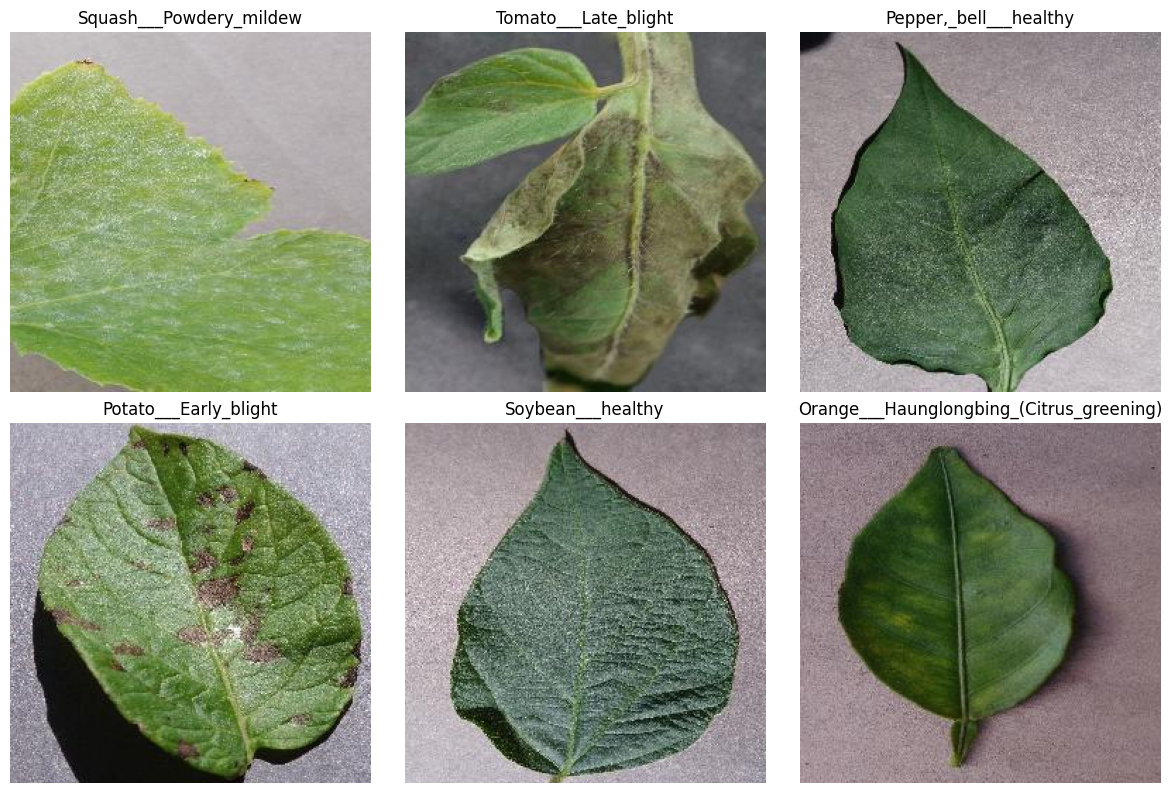

In [7]:
plt.figure(figsize=(12,8))
for i in range(6):
    plt.subplot(2,3,i+1)
    rand_idx = np.random.randint(0, len(data))
    img_path = data.iloc[rand_idx]['filepaths']
    lbl = data.iloc[rand_idx]['labels']
    img = plt.imread(img_path)
    plt.imshow(img)
    plt.title(lbl)
    plt.axis('off')

plt.tight_layout()
plt.show()

### **Creating a Pandas DataFrame**
This cell creates a pandas DataFrame from the collected `filepaths` and `labels`. This DataFrame (`data`) will be used for easier manipulation and analysis of the dataset.

In [ ]:
# Split Dataset 
train_df, temp_df = train_test_split(data, test_size=0.2, stratify=data['label_idx'], random_state=42)
val_df, test_df = train_test_split(temp_df, test_size=0.5, stratify=temp_df['label_idx'], random_state=42)

print(f"Train size: {len(train_df)}")
print(f"Validation size: {len(val_df)}")
print(f"Test size: {len(test_df)}")

Train size: 43444
Validation size: 5430
Test size: 5431


## Data Preprocessing

Before training the model, several preprocessing steps are applied to ensure data quality and model stability:

* Image resizing to a fixed resolution for uniform input
* Normalization of pixel values to improve convergence
* Label encoding for categorical disease classes
* Dataset splitting into **training**, **validation**, and **test** sets
* Optional data augmentation to reduce overfitting and improve generalization

Data augmentation techniques may include:

* Horizontal/vertical flipping
* Rotation
* Zooming
* Brightness adjustment


In [ ]:
# Albumentations Transforms
train_transform = A.Compose([
    A.Resize(224, 224),
    A.HorizontalFlip(p=0.5),
    A.VerticalFlip(p=0.5),
    A.Rotate(limit=30, p=0.5),
    A.RandomBrightnessContrast(brightness_limit=0.2, contrast_limit=0.2, p=0.5),
    A.ShiftScaleRotate(shift_limit=0.1, scale_limit=0.1, rotate_limit=15, p=0.5),
    # A.OneOf([
    #     A.GaussNoise(var_limit=(10.0, 50.0)),
    #     A.GaussianBlur(blur_limit=(3, 7)),
    #     A.MotionBlur(blur_limit=5),
    # ], p=0.3),
    A.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ToTensorV2()
])

val_test_transform = A.Compose([
    A.Resize(224, 224),
    A.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ToTensorV2()
])

In [ ]:
# Custom Dataset
class PlantDiseaseDataset(Dataset):
    def __init__(self, dataframe, transform=None):
        self.dataframe = dataframe.reset_index(drop=True)
        self.transform = transform
    
    def __len__(self):
        return len(self.dataframe)
    
    def __getitem__(self, idx):
        img_path = self.dataframe.loc[idx, 'filepaths']
        label = self.dataframe.loc[idx, 'label_idx']
        
        # Read image
        image = cv.imread(img_path)
        image = cv.cvtColor(image, cv.COLOR_BGR2RGB)
        
        # Apply transforms
        if self.transform:
            transformed = self.transform(image=image)
            image = transformed['image']
        
        return image, label

# Create datasets
train_dataset = PlantDiseaseDataset(train_df, transform=train_transform)
val_dataset = PlantDiseaseDataset(val_df, transform=val_test_transform)
test_dataset = PlantDiseaseDataset(test_df, transform=val_test_transform)

# Create dataloaders
batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=2)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=2)

## Deep Learning Approach

We use a **Convolutional Neural Network (CNN)** architecture, which is well-suited for image classification tasks due to its ability to capture spatial hierarchies and local patterns.

### Why CNNs?

* Automatically extract relevant visual features
* Translation-invariant feature detection
* Strong performance on image-based tasks

## Model Architecture

The model architecture typically consists of:

* Convolutional layers for feature extraction
* Activation functions (e.g., ReLU) to introduce non-linearity
* Pooling layers to reduce spatial dimensions
* Fully connected layers for classification
* Output layer with Softmax (multiclass) or Sigmoid (binary classification)

Regularization techniques such as **Dropout** may be used to prevent overfitting.

In [ ]:
# CNN Model
class PlantDiseaseCNN(nn.Module):
    def __init__(self, num_classes, image_size=224, channel=3):
        super(PlantDiseaseCNN, self).__init__()
        
        # Convolutional blocks
        self.conv_block1 = nn.Sequential(
            nn.Conv2d(channel, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2)
        )
        
        self.conv_block2 = nn.Sequential(
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2)
        )
        
        self.conv_block3 = nn.Sequential(
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(128, 128, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            nn.Dropout(0.2)
        )
        
        # Calculate the flattened size after conv layers
        flatten_size = 128 * (image_size // 8) * (image_size // 8)
        
        # Fully connected layers
        self.fc = nn.Sequential(
            nn.Flatten(),
            nn.Linear(flatten_size, 256),
            nn.ReLU(),
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(128, num_classes)
        )
    
    def forward(self, x):
        x = self.conv_block1(x)
        x = self.conv_block2(x)
        x = self.conv_block3(x)
        x = self.fc(x)
        return x

In [12]:
# ==================== Training Function ====================
def train_epoch(model, loader, criterion, optimizer, device):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    
    for images, labels in loader:
        images, labels = images.to(device), labels.to(device)
        
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
    
    epoch_loss = running_loss / len(loader)
    epoch_acc = 100 * correct / total
    return epoch_loss, epoch_acc


In [13]:
# ==================== Validation Function ====================
def validate(model, loader, criterion, device):
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0
    
    with torch.no_grad():
        for images, labels in loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            
            running_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    
    epoch_loss = running_loss / len(loader)
    epoch_acc = 100 * correct / total
    return epoch_loss, epoch_acc

## Model Compilation

During compilation, the following components are defined:

* **Loss function**

  * Categorical Cross-Entropy (for multiclass)
  * Binary Cross-Entropy (for binary classification)

* **Optimizer**

  * Adam optimizer for efficient gradient-based learning

* **Evaluation metrics**

  * Accuracy
  * Precision, Recall


In [ ]:
# Initialize Model and Training 
num_classes = len(unique_labels)
model = PlantDiseaseCNN(num_classes).to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.3, patience=3, verbose=True)

# Training loop
num_epochs = 30
best_val_acc = 0.0
train_losses, val_losses = [], []
train_accs, val_accs = [], []

print("\n" + "="*60)
print("Starting Training...")
print("="*60)

for epoch in range(num_epochs):
    train_loss, train_acc = train_epoch(model, train_loader, criterion, optimizer, device)
    val_loss, val_acc = validate(model, val_loader, criterion, device)
    
    train_losses.append(train_loss)
    val_losses.append(val_loss)
    train_accs.append(train_acc)
    val_accs.append(val_acc)
    
    scheduler.step(val_loss)
    
    print(f"Epoch [{epoch+1}/{num_epochs}]")
    print(f"  Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.2f}%")
    print(f"  Val Loss: {val_loss:.4f} | Val Acc: {val_acc:.2f}%")
    
    # Save best model
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        torch.save(model.state_dict(), 'best_plant_disease_model.pth')
        print(f"  ✓ New best model saved! (Val Acc: {val_acc:.2f}%)")
    print("-"*60)


Starting Training...
Epoch [1/30]
  Train Loss: 2.3620 | Train Acc: 35.39%
  Val Loss: 1.2696 | Val Acc: 61.75%
  ✓ New best model saved! (Val Acc: 61.75%)
------------------------------------------------------------
Epoch [2/30]
  Train Loss: 1.2975 | Train Acc: 60.86%
  Val Loss: 0.7864 | Val Acc: 74.27%
  ✓ New best model saved! (Val Acc: 74.27%)
------------------------------------------------------------
Epoch [3/30]
  Train Loss: 0.9043 | Train Acc: 72.41%
  Val Loss: 0.4766 | Val Acc: 84.48%
  ✓ New best model saved! (Val Acc: 84.48%)
------------------------------------------------------------
Epoch [4/30]
  Train Loss: 0.7080 | Train Acc: 78.49%
  Val Loss: 0.3648 | Val Acc: 88.18%
  ✓ New best model saved! (Val Acc: 88.18%)
------------------------------------------------------------
Epoch [5/30]
  Train Loss: 0.6018 | Train Acc: 81.65%
  Val Loss: 0.3080 | Val Acc: 90.39%
  ✓ New best model saved! (Val Acc: 90.39%)
-----------------------------------------------------------

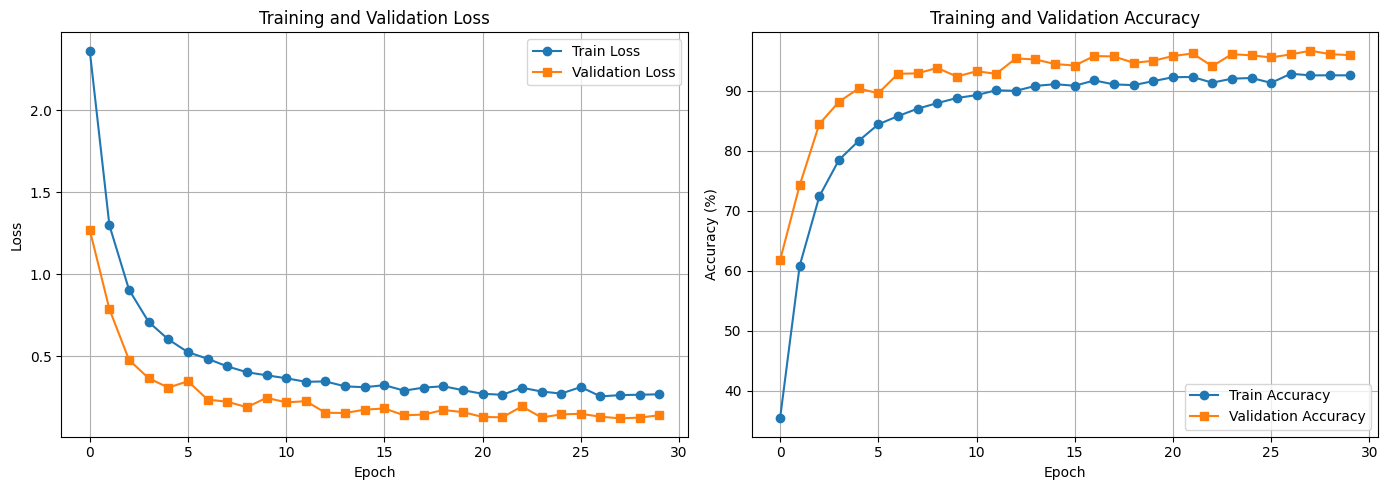

In [ ]:
# Plot Training History
plt.figure(figsize=(14, 5))

plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss', marker='o')
plt.plot(val_losses, label='Validation Loss', marker='s')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(train_accs, label='Train Accuracy', marker='o')
plt.plot(val_accs, label='Validation Accuracy', marker='s')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.title('Training and Validation Accuracy')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()


## Model Evaluation

After training, the model is evaluated on the unseen test dataset.

Evaluation metrics include:

* Overall accuracy
* Class-wise performance
* Confusion matrix 

These metrics help assess how well the model generalizes to new plant images.

 

In [ ]:
# Evaluate on Test Set 
model.load_state_dict(torch.load('best_plant_disease_model.pth'))
test_loss, test_acc = validate(model, test_loader, criterion, device)
print(f"\n{'='*60}")
print(f"Test Loss: {test_loss:.4f} | Test Accuracy: {test_acc:.2f}%")
print(f"{'='*60}")



Test Loss: 0.1381 | Test Accuracy: 96.13%


In [ ]:
# Confusion Matrix 
model.eval()
all_preds = []
all_labels = []

with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(labels.numpy())

cm = confusion_matrix(all_labels, all_preds)
print("\nClassification Report:")
print(classification_report(all_labels, all_preds, target_names=unique_labels))


Classification Report:
                                                    precision    recall  f1-score   support

                              Tomato___Late_blight       0.94      0.86      0.90       191
                                  Tomato___healthy       0.99      0.99      0.99       159
                                   Grape___healthy       0.97      0.90      0.94        42
          Orange___Haunglongbing_(Citrus_greening)       0.99      1.00      1.00       551
                                 Soybean___healthy       0.98      0.99      0.99       509
                           Squash___Powdery_mildew       0.98      1.00      0.99       184
                                  Potato___healthy       0.86      0.80      0.83        15
               Corn_(maize)___Northern_Leaf_Blight       0.90      0.95      0.93        98
                             Tomato___Early_blight       0.84      0.79      0.81       100
                       Tomato___Septoria_leaf_spot     

## Results and Discussion

Key observations from the results:

* The model successfully learns visual disease patterns
* Certain diseases may be harder to classify due to visual similarity
* Data quality and class balance significantly affect performance

 


 
